# Getting started with FARiCube Hub
In this demo you will see
- how to ingest raster data to SentinelHub
- how to request data from SentinelHub
- how to process a simple data cube and compute zonal statistics

The objective of this demo is to compute the share of Urban Atlas classes in a sample city.

We will use the following data:
- Urban Audit City
- Urban Atlas
- city bounding boxes lookup table

As bonus, you will see how to combine a private ingested dataset (Urban Audit City) with a publicly available EDC dataset (population density).

First we load required packages and secrets.

In [1]:
%matplotlib inline

import datetime as dt

# Utilities
import boto3
import dateutil
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
import rasterio
# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import zarr

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    os_utils,
)

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")

## Ingest data to SentinelHub
We are going to ingest tiles of the Urban Atlas City. The tiles are saved in Cloud Optimized GeoTiff format (COG) in the s3 bucket.

First we create an empty collection, and then upload the tiles. This step can take some time, depending on the service availabilty. When a tile has finished uploading, its status changes to "INGESTED".

In [2]:
# Initialize SentinelHubBYOC class
byoc = SentinelHubBYOC(config=config)

new_collection = ByocCollection(name="UrbanAtlas2018_10m_raster_demo", s3_bucket="hub-fairicube0")
created_collection = byoc.create_collection(new_collection)
my_collection = byoc.get_collection(created_collection["id"])


# path to collection tiles
input_folder ="data/d002_urban_atlas"
tile_list = [
        "ua2018_mosaic_raster_10m_cog_5_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_1_(BAND).tif"
            ]

# ingest tiles
for tile in tile_list:
    path_link = input_folder+"/"+tile
    new_tile = ByocTile(path=path_link) 
    created_tile = byoc.create_tile(created_collection, new_tile)
    tile = byoc.get_tile(collection=created_collection["id"], tile=created_tile["id"])

Check the ingestion status

In [12]:
# check ingestion status
collections_iterator = byoc.iter_collections("UrbanAtlas2018_10m_raster_demo")
my_collection = list(collections_iterator)[0]
print("Collection name:", my_collection["name"])
print("Collection id: ", my_collection["id"])
tiles = list(byoc.iter_tiles(my_collection))
for tile in tiles:
    print("Tile status: ", tile['status'])
    print("Tile created: ", tile['created'])

Collection name: UrbanAtlas2018_10m_raster_demo
Collection id:  85c901ac-78c3-4cb3-af8c-892d2b362049
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:20.848577Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:19.646812Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:18.186341Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:18.499661Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:20.147246Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:20.348365Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:18.292628Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:19.945336Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:18.707875Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:19.332111Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:20.748545Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:18.608296Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:19.847494Z
Tile status:  INGESTED
Tile created:  202

In [4]:
# delete collection
# byoc.delete_collection(my_collection)

Let's see all ingested collections. We can optionally print the datail of the tiles as well

In [11]:
# list all ingested collections
collections_iterator = byoc.iter_collections()
my_collections = list(collections_iterator)
for collection in my_collections:
    
    print("Collection name:", collection["name"])
    print("Collection id: ", collection["id"])
#     tiles = list(byoc.iter_tiles(collection))
#     for tile in tiles:
#         print("Tile status: ", tile['status'])
#         print("Tile created: ", tile['created'])
#         print("Tile path: ", tile['path'])
#         if(tile['status'] == "FAILED"):
#             print("Ingestion failed error: ", tile['additionalData'])
    print("-------------------")
# print ("end")

Collection name: urban_audit_2021_city
Collection id:  20774d38-7b2e-43e9-b574-66fa2954da1c
-------------------
Collection name: nuts3_2021
Collection id:  81a17892-38ff-470a-ae46-b64313acd7b3
-------------------
Collection name: UrbanAtlas2018_10m_raster_demo
Collection id:  85c901ac-78c3-4cb3-af8c-892d2b362049
-------------------
Collection name: urban_audit_2021_fua
Collection id:  b17f90da-1308-439e-b675-6e3a87f883de
-------------------
Collection name: nuts3_2021
Collection id:  ed7c0bf4-e85f-498c-ad18-f3e83fb89a6f
-------------------


## Request data from SentinelHub
We are ready to build our first cube!

First, we define the bounding box. The lookup table `URAU_city_bboxes_3035.csv` contains the list of cities and respective bounding boxes, with CRS EPSG:3035.

We choose the beautiful city of Verona.

In [6]:
# define bounding box
# load cities bounding boxes
c_bb = pd.read_csv("./../../../s3/data/d000_lookuptables/URAU_city_bboxes_3035.csv")
# select one city
row = c_bb[c_bb.URAU_NAME == "Verona"]
resolution = 10
bbox_coords = row.minx, row.miny, row.maxx, row.maxy
bbox = BBox(bbox=bbox_coords, crs=CRS('3035').pyproj_crs())
bbox_size = bbox_to_dimensions(bbox, resolution=resolution)
# plot bounding box
IPython.display.GeoJSON(shapely.geometry.box(*bbox.transform_bounds(CRS.WGS84)).__geo_interface__)

<IPython.display.GeoJSON object>

Second, we define the dimensions. In SentinelHub, each collection has a unique `collectionId`. We listed all collectionnames and ids above.

In [15]:
# URAU Cities
collection_id_city = "20774d38-7b2e-43e9-b574-66fa2954da1c"
collection_name_city = "urban_audit_2021_city"
data_collection_city = DataCollection.define_byoc(collection_id_city, name=collection_name_city)
# Urban atlas
collection_id_UA = "85c901ac-78c3-4cb3-af8c-892d2b362049"
collection_name_UA = "UrbanAtlas2018_10m_raster_demo"
data_collection_UA = DataCollection.define_byoc(collection_id_UA, name=collection_name_UA)

The last ingredient for the SentinelHub request is the `evalscript`, which tells SH how to deliver the datacube. Here, we want to simply get the two collections in two separate layers. See later for a more complex `evalscript`.

In [16]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [
            {
                datasource: "city",
                bands: ["B1"]
            },
            {
                datasource: "UA",
                bands: ["B1"]
            }],
            output: {
                bands: 2,
                sampleType: "UINT16" // raster format will be UINT16
            }
        };
    }

    function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
        var sample_city = samples.city[0]
        var sample_ua = samples.UA[0]
        return [sample_city.B1, sample_ua.B1];

      
    }
"""
input_data = [
        SentinelHubRequest.input_data(
            data_collection=DataCollection.urban_audit_2021_city,
            identifier="city",
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.UrbanAtlas2018_10m_raster_demo,
            identifier="UA",
        )
    ]
request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=input_data,
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=bbox_size,
        config=config
    )

data = request.get_data()[0]

The request returns a 3d numpy array.

In [19]:
# check dimensions and type
print(data.shape, type(data))

(2169, 1902, 2) <class 'numpy.ndarray'>


Let's see if the request was successful: if so, we can plot one dimension.

Success!


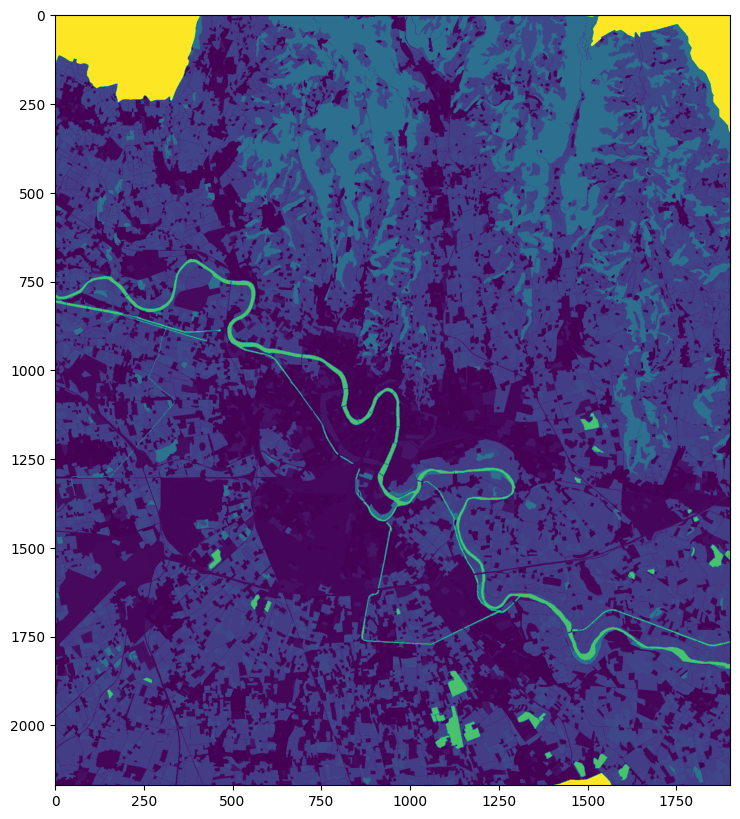

In [22]:
# is there anything in the data?
import numpy as np
if(np.std(data) == 0): 
    print("Error: data is empty :(")
else:
    print("Success!")
    # plot data
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(data[:,:,1])

## Compute zonal statistics
For each Urban Atlas class, we compute the number of pixels within the city. The result is a pandas DataFrame, which we can later save as .csv, or directly into the database.

Check out the demo notebook `demo_urban_profile_viz.ipynb` for a visualization of the result.

In [28]:
# compute accounting table
b1 = data[:,:,0]
b2 = data[:,:,1]

bands2df = {
    "city_code": pd.Series(b1.ravel()),
    "urban_atlas_2018": pd.Series(b2.ravel())
   }

df = pd.DataFrame(data=bands2df)

### combine:
combine_table_cube_urban=df.groupby(['city_code','urban_atlas_2018']).size().reset_index().rename(columns={0:'count'})

Let's plot the DataFrame. Each row gives the pixel count for a combination of a Urban Atlas class and a city code.

The column `city_code` has either the numerical code for Verona (608), or the nodata value (65535). That means that we computed the pixel count for each Urban Atlas class within the city (city_code = 608) and outside of the city (city_code = 65535). The latter rows can therefore be discarded.

More information about the Urban Atlas classes can be found in the mapping guide: https://land.copernicus.eu/user-corner/technical-library/urban-atlas-mapping-guide

In [29]:
combine_table_cube_urban

,city_code,urban_atlas_2018,count
0,608,11100,67326
1,608,11210,90336
2,608,11220,51197
3,608,11230,40915
4,608,11240,9583
5,608,11300,41268
6,608,12100,264899
7,608,12210,7365
8,608,12220,103924
9,608,12230,18936


## Bonus: Request data from EDC catalog

So far we have used our own collections. But it is possible to request other publicly available collections in the same way. 

Let's combine the city dimension with the population density dataset, which is available in the EuroDataCube catalog: https://collections.eurodatacube.com/population_density/.

In the catalog we find the SentinelHub CollectionId, which we use to request the collection.

In [31]:
# population density
# https://collections.eurodatacube.com/population_density/
data_collection_pop = DataCollection.define_byoc("b468089b-2627-4787-b984-89c10434f6c6")

In this request, istead of getting two dimensions, we combine the two collections into one single dimension.

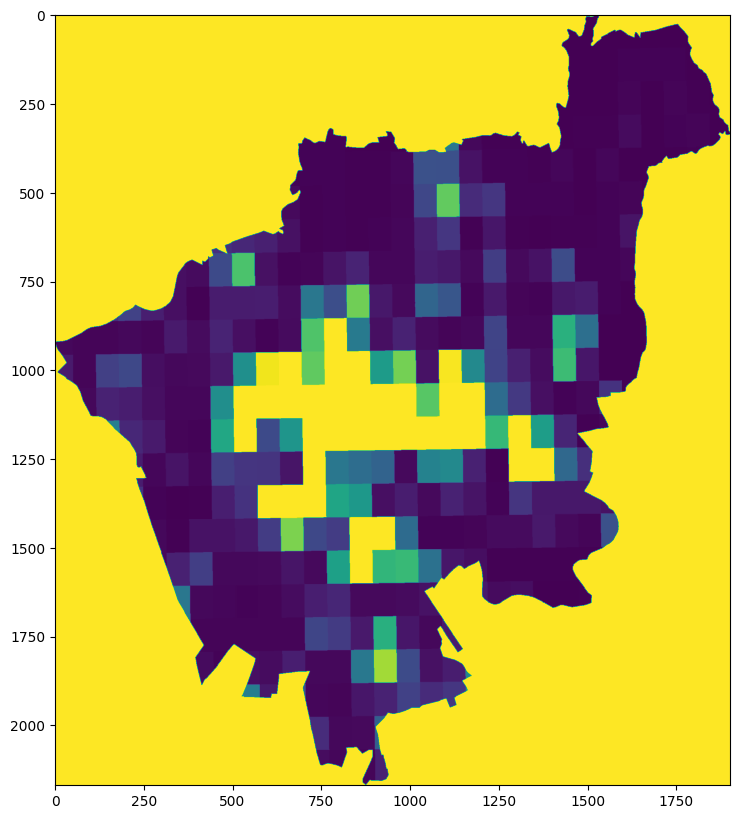

In [37]:
evalscript_combi = """
//VERSION=3
function setup() {
  return {
    input: [{
        datasource: "city",
        bands: ["B1"]
      },
      {
        datasource: "pop",
        bands: ["populationDensity"]
      }],
    output: [{
      bands: 1,
      sampleType: "UINT16" // raster format will be UINT16
    }]
  }
}


function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
  var city = samples.city[0]
  var pop = samples.pop[0]
  
  if(city.B1 == null) {
      return [65535];
  }
  else {
      return [city.B1*100+pop.populationDensity];
  }
}
"""

request = SentinelHubRequest(
    evalscript=evalscript_combi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.urban_audit_2021_city,
            identifier="city",  # has to match Sentinel input datasource id in evalscript
        ),
        SentinelHubRequest.input_data(
            data_collection=data_collection_pop,
            identifier="pop",  # has to match Sentinel input datasource id in evalscript
        ),
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    size=bbox_size,
    config=config,
)

image = request.get_data()[0]

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(image)